Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

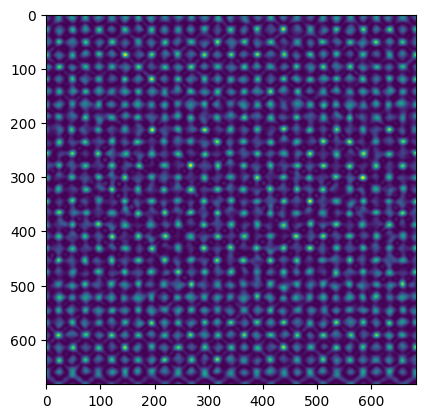

In [1]:
import pyms
import numpy as np
import torch
#TODO: LOWENA, this first cell is just so you can see how this package works, play around with the defocus a bit
# Get crystal
crystal = pyms.structure.fromfile(
    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
# structure
crystal = crystal.resize([0.1, 0.76], axis=0)
from copy import deepcopy

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)


# Quick plot of crystal
# crystal.quickplot(atomscale=1e-5)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])

# Set up  series of defocii
df = np.array([100.0])


output = pyms.HRTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    df=df,
    tiling=tiling,
    nfph=1,
    showProgress='notebook'
)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(output)



In [2]:
#TODO: LOWENA here is the chi function. First thing we want to so is
# just make df differentiable. You can try editing in this notebook
# first run this cell, then run the cell below to call this function
# I've set it up for you to run some dummy data
# Everytime you edit the function, re run the cell
# your goal is to change df from a float array to a tensor with requires_grad=True
# To make everything differentiable, you'll also need to make the output a tensor
def chi(q, qphi, lam, df=0.0, aberrations=[]):
    r"""
    Calculate the aberration function, chi.

    Parameters
    ----------
    q : float or array_like
        Reciprocal space extent (Inverse angstroms).
    qphi : float or array_like
        Azimuth of grid in radians
    lam : float
        Wavelength of electron (Inverse angstroms).
    df : float, optional
        Defocus in Angstrom
    aberrations : list, optional
        A list containing a set of the class aberration, pass an empty list for
        an unaberrated contrast transfer function.
    Returns
    -------
    chi : float or array_like
        The aberration function, will be the same shape as `q`. This is used to
        calculate the probe wave function in reciprocal space.
    """
    qlam = q * lam
    chi_ = qlam ** 2 / 2 * df
    for ab in aberrations:
        chi_ += (
            qlam ** (ab.n + 1)
            * float(ab.amplitude)
            / (ab.n + 1)
            * np.cos(ab.m * (qphi - float(ab.angle)))
        )
    return 2 * np.pi * chi_ / lam

In [9]:
test = chi(q = 1.3, qphi = 0.2, lam = 2e5, df = 0.1, aberrations = [])

In [10]:
test

106185.83169133501

In [16]:
#Now try with df a torch.tensor instead, the code actually works straight away haha
df_torch = torch.tensor([0.1], requires_grad = True)
test = chi(q = 1.3, qphi = 0.2, lam = 2e5, df = df_torch, aberrations = [])

In [17]:
#create some scalar number we can backprop through
test = torch.sum(test**2)
#backprop
test.backward()
#check gradient of df_torch, we have a number so it's working!
print(df_torch.grad)

tensor([2.2551e+11])
